## **Load *Monod*+meK-Means and Packages**

In [1406]:
import sys
sys.path.insert(0, '/home/tchari/monod/src/')

In [1407]:
import monod
from monod import preprocess, extract_data, cme_toolbox, inference, analysis, mminference

In [1408]:
import pandas as pd
import numpy as np
import loompy as lp
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import scipy.stats

from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, ExtraTreesRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.metrics import accuracy_score, classification_report

import os

import sklearn
import scanpy as sc
import anndata

In [1409]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## **Load Metadata and Select Genes for Inference Across Conditions**

In [1410]:
#Test with controls for now, and remove later if necessary 

In [1607]:
meta_path = "/home/tchari/metadata/"
meta = pd.read_csv(meta_path+'norman_GSE133344_filtered_cell_identities.csv')
meta.head()

,cell_barcode,guide_identity,read_count,UMI_count,coverage,gemgroup,good_coverage,number_of_cells
0,TTGAACGAGACTCGGA-2,ARID1A_NegCtrl0__ARID1A_NegCtrl0,28684,1809,15.856274,2,True,1
1,CGTTGGGGTGTTTGTG-7,BCORL1_NegCtrl0__BCORL1_NegCtrl0,18367,896,20.498884,7,True,1
2,GAACCTAAGTGTTAGA-6,FOSB_NegCtrl0__FOSB_NegCtrl0,16296,664,24.542169,6,True,1
3,CCTTCCCTCCGTCATC-4,SET_KLF1__SET_KLF1,16262,850,19.131765,4,True,1
4,TCAATCTGTCTTTCAT-2,OSR2_NegCtrl0__OSR2_NegCtrl0,16057,1067,15.048735,2,True,2


In [1608]:
ids = list(meta['guide_identity'].value_counts().index)
counts = list(meta['guide_identity'].value_counts())

saveCounts = pd.DataFrame()
saveCounts['guide_identity'] = ids
saveCounts['cells'] = counts
saveCounts.head()

,guide_identity,cells
0,NegCtrl10_NegCtrl0__NegCtrl10_NegCtrl0,3532
1,NegCtrl1_NegCtrl0__NegCtrl1_NegCtrl0,2948
2,NegCtrl11_NegCtrl0__NegCtrl11_NegCtrl0,2839
3,NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0,2536
4,CEBPE_RUNX1T1__CEBPE_RUNX1T1,1219


In [1683]:
saveCounts[saveCounts['guide_identity'].isin(['CEBPE_RUNX1T1__CEBPE_RUNX1T1'])]

,guide_identity,cells
4,CEBPE_RUNX1T1__CEBPE_RUNX1T1,1219


In [1684]:
[i for i in saveCounts['guide_identity'] if 'CEBPE' in i]

['CEBPE_RUNX1T1__CEBPE_RUNX1T1',
 'NegCtrl0_CEBPE__NegCtrl0_CEBPE',
 'SET_CEBPE__SET_CEBPE',
 'CEBPE_NegCtrl0__CEBPE_NegCtrl0',
 'CEBPE_KLF1__CEBPE_KLF1',
 'CEBPE_PTPN12__CEBPE_PTPN12',
 'ZC3HAV1_CEBPE__ZC3HAV1_CEBPE',
 'ETS2_CEBPE__ETS2_CEBPE',
 'CEBPE_CNN1__CEBPE_CNN1',
 'CEBPE_CEBPA__CEBPE_CEBPA',
 'CEBPE_SPI1__CEBPE_SPI1',
 'FOSB_CEBPE__FOSB_CEBPE',
 'CEBPE_CEBPB__CEBPE_CEBPB']

In [1686]:
[i for i in saveCounts['guide_identity'] if 'MAPK1' in i]

['MAPK1_PRTG__MAPK1_PRTG',
 'MAPK1_TGFBR2__MAPK1_TGFBR2',
 'ETS2_MAPK1__ETS2_MAPK1',
 'NegCtrl0_MAPK1__NegCtrl0_MAPK1',
 'CEBPB_MAPK1__CEBPB_MAPK1',
 'CNN1_MAPK1__CNN1_MAPK1',
 'IGDCC3_MAPK1__IGDCC3_MAPK1',
 'MAPK1_NegCtrl0__MAPK1_NegCtrl0',
 'MAPK1_IKZF3__MAPK1_IKZF3',
 'DUSP9_MAPK1__DUSP9_MAPK1']

In [1256]:
saveCounts[saveCounts['guide_identity'].isin(['ETS2_NegCtrl0__ETS2_NegCtrl0'])]

,guide_identity,cells
64,ETS2_NegCtrl0__ETS2_NegCtrl0,451


Filter for conditions with > 100 cells (since we're looking for possible subpopulations/states etc)

In [1823]:
#ctrls = ['NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0'] 
ctrls = ['NegCtrl10_NegCtrl0__NegCtrl10_NegCtrl0','NegCtrl11_NegCtrl0__NegCtrl11_NegCtrl0',
         'NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0','NegCtrl1_NegCtrl0__NegCtrl1_NegCtrl0']

ctrl_bars = list(meta.cell_barcode[meta.guide_identity.isin(ctrls)])

#conds_only = list(saveCounts['guide_identity'][(saveCounts['cells'] >  500) & (~saveCounts['guide_identity'].isin(ctrls))])
conds_only = ['CEBPE_RUNX1T1__CEBPE_RUNX1T1']

#conds_only = ['DUSP9_MAPK1__DUSP9_MAPK1','DUSP9_NegCtrl0__DUSP9_NegCtrl0','NegCtrl0_MAPK1__NegCtrl0_MAPK1' ]
#'DUSP9_MAPK1__DUSP9_MAPK1','MAPK1_NegCtrl0__MAPK1_NegCtrl0'
#['DUSP9_ETS2__DUSP9_ETS2','ETS2_NegCtrl0__ETS2_NegCtrl0','DUSP9_NegCtrl0__DUSP9_NegCtrl0']

filt_ids = conds_only+ctrls   #list(saveCounts['guide_identity'][(saveCounts['cells'] >  100)])
#list(saveCounts['guide_identity'][(saveCounts['cells'] >  100) & ~saveCounts['guide_identity'].isin(ctrls)])
len(filt_ids)

5

In [1824]:
filt_bars = list(meta.cell_barcode[meta.guide_identity.isin(filt_ids)])

In [1825]:
filt_conds_bars = list(meta.cell_barcode[meta.guide_identity.isin(conds_only)])

**For all pair conditions, find matching single conds and extract important genes**

In [1826]:
import random

In [1827]:
def input_for_sel(S1,S2,SC):
    '''
    Take in S counts for cond11,2,and control and if there is only one condition
    Normalize/scale S counts for test/train data for classifier
    Output normalized data (only for cond1/2 and control)
    '''
    
    X1 = S1 #cellxgene
    X2 = S2

    X_ctrl = SC
    
    min_size = np.min([X1.shape[0],X2.shape[0],X_ctrl.shape[0]])
    sub_inds = [] 
    for x in [X1,X2,X_ctrl]:
         sub_inds += [random.sample(range(x.shape[0]),min_size)] #Keep equal sized samples
            
    #sub_inds = random.sample(range(X_ctrl.shape[0]),X2.shape[0])
    X1 = X1[sub_inds[0],:]
    X2 = X2[sub_inds[1],:]
    X_ctrl = X_ctrl[sub_inds[2],:]

    X_conds = np.concatenate((X1,X2),axis=0) #X_both


    Y_conds = ['Cond1']*X1.shape[0]+['Cond2']*X2.shape[0] #+[dataset_names[inds[2]]]*X_both.shape[0]
    Y_conds_ctrl = Y_conds + ['Ctrl']*X_ctrl.shape[0]

    Y_conds = np.array(Y_conds)
    Y_conds_ctrl = np.array(Y_conds_ctrl)

    #dataset_names[i]

    #Scale cell reads, * median_reads/reads
    condTot = np.sum(X_conds,axis=1)
    median = np.median(condTot)
    ctrlTot = np.sum(X_ctrl,axis=1)
    facts = median/condTot
    factsCtrl = median/ctrlTot


    X_conds_norm = X_conds*np.repeat(facts.reshape(-1, 1), X_conds.shape[1], 1)
    X_ctrl_norm = X_ctrl*np.repeat(factsCtrl.reshape(-1, 1), X_ctrl.shape[1], 1)

    #Scale controls to same median
    X_conds_ctrl_norm = np.concatenate((X_conds_norm,X_ctrl_norm),axis=0)

    #From each cond, subtract ctrl mean and /std dev (Z-normalization)
    ctrl_mu = np.mean(X_ctrl_norm,axis=0) #For each gene
    ctrl_std = np.std(X_ctrl_norm,axis=0)


    X_conds_norm = (X_conds_norm-ctrl_mu)/(ctrl_std+1e-4) #Can lead to divide by zeros
    X_conds_ctrl_norm = (X_conds_ctrl_norm-ctrl_mu)/(ctrl_std+1e-4)
    
    return X_conds_ctrl_norm, Y_conds_ctrl


In [1828]:
def single_input_for_sel(S1,SC):
    '''
    Take in S counts for cond11,2,and control and if there is only one condition
    Normalize/scale S counts for test/train data for classifier
    Output normalized data (only for cond1/2 and control)
    '''
    
    X1 = S1 #cellxgene

    X_ctrl = SC
    
    min_size = np.min([X1.shape[0],X_ctrl.shape[0]])
    sub_inds = [] 
    for x in [X1,X_ctrl]:
         sub_inds += [random.sample(range(x.shape[0]),min_size)] #Keep equal sized samples
            
    #sub_inds = random.sample(range(X_ctrl.shape[0]),X2.shape[0])
    X1 = X1[sub_inds[0],:]
    X_ctrl = X_ctrl[sub_inds[1],:]

    X_conds = X1#X_both


    Y_conds = ['Cond1']*X1.shape[0]#+[dataset_names[inds[2]]]*X_both.shape[0]
    Y_conds_ctrl = Y_conds + ['Ctrl']*X_ctrl.shape[0]

    Y_conds = np.array(Y_conds)
    Y_conds_ctrl = np.array(Y_conds_ctrl)

    #dataset_names[i]

    #Scale cell reads, * median_reads/reads
    condTot = np.sum(X_conds,axis=1)
    median = np.median(condTot)
    ctrlTot = np.sum(X_ctrl,axis=1)
    facts = median/condTot
    factsCtrl = median/ctrlTot


    X_conds_norm = X_conds*np.repeat(facts.reshape(-1, 1), X_conds.shape[1], 1)
    X_ctrl_norm = X_ctrl*np.repeat(factsCtrl.reshape(-1, 1), X_ctrl.shape[1], 1)

    #Scale controls to same median
    X_conds_ctrl_norm = np.concatenate((X_conds_norm,X_ctrl_norm),axis=0)

    #From each cond, subtract ctrl mean and /std dev (Z-normalization)
    ctrl_mu = np.mean(X_ctrl_norm,axis=0) #For each gene
    ctrl_std = np.std(X_ctrl_norm,axis=0)


    X_conds_norm = (X_conds_norm-ctrl_mu)/(ctrl_std+1e-4) #Can lead to divide by zeros
    X_conds_ctrl_norm = (X_conds_ctrl_norm-ctrl_mu)/(ctrl_std+1e-4)
    
    return X_conds_ctrl_norm, Y_conds_ctrl


In [1497]:
def sel_genes(X_conds_ctrl_norm ,Y_conds_ctrl,g_names_2, test_size=0.2,n_jobs = 10,num_features = 100):
    '''
    Take in scaled counts for cond1/2, & control,.
    Split data into test/train for classifier and extract top predictive genes.
    Output top genes for prediction condition label.
    '''
    
    test_size = test_size
    n_jobs = n_jobs

    X = X_conds_ctrl_norm 
    Y = Y_conds_ctrl

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=42, stratify=Y)

    #From https://github.com/thomasmaxwellnorman/Perturbseq_GI/blob/3b25109aeb9c0c2026bd70abd50304a0ad4e5395/perturbseq/differential_expression.py#L213
    f_repr = 100
    # n_feat * 2 because the training matrix is extended with n shadow features
    multi = ((X_train.shape[1] * 2) / (np.sqrt(X_train.shape[1] * 2) * 10))
    n_estimators = int(multi * f_repr)
    #print('n_estimators: ',n_estimators)

    #.fit()
    clf_tree = ExtraTreesClassifier(n_jobs=n_jobs, n_estimators=n_estimators, class_weight='balanced', random_state=42)
    clf_tree.fit(X_train, Y_train)

    #.predict() on X_test
    Y_pred = clf_tree.predict(X_test)

    #get accuracy_score and classification_report
    acc = accuracy_score(Y_test, Y_pred)
    print('Feature prediction accuracy (test size: {1:.1f}%): {0}\n'.format(acc, 100*test_size))
    
    print('Unpredicted labels: ', set(Y_test) - set(Y_pred))
   
    
    report = classification_report(Y_test, Y_pred)
    print(report)


    #get feature_importances
    num_features = num_features #Top 100 genes for now

    idx = np.argsort(clf_tree.feature_importances_)[::-1]
    gene_indices = idx[0:num_features]
    top_gene_names = g_names_2[gene_indices] 
    
    plt.scatter(range(len(idx)),clf_tree.feature_importances_[idx])
    plt.vlines(f_repr,np.min(clf_tree.feature_importances_[idx]),np.max(clf_tree.feature_importances_[idx]))
    
    return top_gene_names


In [1426]:
#Not 'Neg' paired conds
notNeg = [f for f in filt_ids if 'Neg' not in f]

In [1800]:
first = [conds_only[0]]#[conds_only[1]] #i.split('_')[0] for i in notNeg
secnd = [conds_only[0]]#[conds_only[2]] #i.split('_')[1] for i in notNeg

#all_targets = np.unique(first+secnd)

In [1428]:
#Get full count matrices and barcodes
ds = lp.connect('/home/tchari/counts/norman_crispr/loom/allcrispr.loom')
U = ds.layers['unspliced'][:].T
S = ds.layers['spliced'][:].T
bars = ds.ca['barcode']
g_names = ds.ra['gene_name']
ds.close()

In [1429]:
S.shape

(116844, 36601)

In [1829]:
#Select genes to begin with that have enough U/S counts
filt_param={
        "min_U_mean": 0.01,
        "min_S_mean": 0.01,
        "max_U_max": 400,
        "max_S_max": 400,
        "min_U_max": 3,
        "min_S_max": 3,
    } #4,4

expr_filt = monod.preprocess.threshold_by_expression(S.T[:,np.isin(bars,filt_conds_bars)],
                                                     U.T[:,np.isin(bars,filt_conds_bars)],
                                                     filt_param) #[:,np.isin(bars,filt_bars)]

INFO:root:1662 genes retained after expression filter.


In [1830]:
np.sum(expr_filt)

1662

In [1831]:
annots=pd.read_csv('/home/tchari/perturbCME/notebooks/gg_200525_genome_polyA_cum_3',delim_whitespace=True,header=None)
print(annots.head())

filt_markers = [m for m in g_names[expr_filt] if m in list(annots[0])]
len(filt_markers)

       0      1    2   3   4   5   6   7   8   9   ...  39  40  41  42  43  \
0    TNMD  14950   48  23  10   5   2   2   2   2  ...   0   0   0   0   0   
1    DPM1  23689   98  38  25  17  10   6   5   5  ...   0   0   0   0   0   
2   SCYL3  44637  132  51  20  13   9   7   6   4  ...   0   0   0   0   0   
3  TSPAN6  12884   43  18  13   8   3   2   2   1  ...   0   0   0   0   0   
4     FGR  23122   41  18   8   4   1   1   1   1  ...   0   0   0   0   0   

   44  45  46  47  48  
0   0   0   0   0   0  
1   0   0   0   0   0  
2   0   0   0   0   0  
3   0   0   0   0   0  
4   0   0   0   0   0  

[5 rows x 49 columns]


1643

In [1832]:
#Get boolean filter for genes which are also in annotation file
expr_filt2 = np.isin(g_names,filt_markers)

In [1833]:
g_names_2 = g_names[expr_filt2]

In [1834]:
np.sum(expr_filt2)

1643

In [1801]:
#Filter for control condition cells
ctrl_S = S[np.isin(bars,ctrl_bars),:]

In [1802]:
#Filter control cells for selected genes
ctrl_S = ctrl_S[:,expr_filt2] 
ctrl_S.shape

(11855, 3165)

In [1493]:
# all_ids = list(saveCounts['guide_identity'][(saveCounts['cells'] >  100)])

CBL_CNN1__CBL_CNN1 + CBL_CNN1__CBL_CNN1
Feature prediction accuracy (test size: 20.0%): 0.8571428571428571

Unpredicted labels:  set()
              precision    recall  f1-score   support

       Cond1       0.95      0.76      0.84        70
        Ctrl       0.80      0.96      0.87        70

    accuracy                           0.86       140
   macro avg       0.87      0.86      0.86       140
weighted avg       0.87      0.86      0.86       140



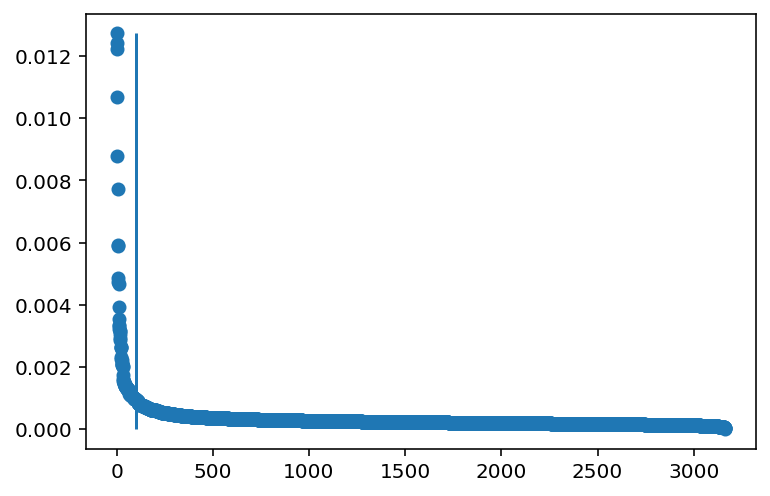

In [1804]:
#Get single conds for first and secnd conds
all_gs_forinf = []
for g in range(len(first)):
    g1 = first[g]
    g2 = secnd[g]
    
    #g1_nms = [f for f in all_ids if (g1 in f and 'Neg' in f)]
    #g2_nms = [f for f in all_ids if (g2 in f and 'Neg' in f)]
    
    print(g1+' + '+g2)
    
    #sub U and S matrices
    bars1 = list(meta.cell_barcode[meta.guide_identity.isin([g1])])
    bars2 = list(meta.cell_barcode[meta.guide_identity.isin([g2])])
    
    if len(bars1) > 0 and len(bars2) > 0:  #May be some guides with no Neg ctrl pair in filtered list
        S1 = S[np.isin(bars,bars1),:]
        S1 = S1[:,expr_filt2]
        S2 = S[np.isin(bars,bars2),:]
        S2 = S2[:,expr_filt2]

        #X,Y = input_for_sel(S1,S2,ctrl_S)
        X,Y = single_input_for_sel(S1,ctrl_S)
        imp_genes = sel_genes(X,Y,g_names_2,num_features=100) #How many top genes to select for each condition

        all_gs_forinf += list(imp_genes)
    else:
        print('no cells for '+str(g))
    

    
    
    
    

In [1805]:
all_gs_forinf = np.unique(all_gs_forinf)
len(all_gs_forinf)

100

In [1806]:
final_filt = np.isin(g_names,all_gs_forinf)

In [1835]:
#Make anndata with conditions and get most variable
only_conds_S = S[np.isin(bars,filt_conds_bars),:] #np.isin(bars,filt_conds_bars)
only_conds_S = only_conds_S[:,expr_filt2]
adata = anndata.AnnData(only_conds_S)

adata.obs_names = [f"Cell_{i:d}" for i in range(adata.n_obs)]
adata.var_names = g_names_2

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  after removing the cwd from sys.path.


In [1836]:
np.sum(adata.var.highly_variable)

222

In [1837]:
all_gs_forinf = list(adata.var_names[adata.var.highly_variable])
final_filt = np.isin(g_names,all_gs_forinf)

In [656]:
# adata

In [1329]:
# d_mk_genes = ['AP1S2','LST1','ARHGDIB','TMSB4X','CD52','AIF1','RPL10','RPS3','PRSS57','PTPN7',
#           'SMAGP','LY6E','TPT1','RPS4X','RPL4','LAPTM5','SUB1','EVA1B','ABRACL','CMBL',
#           'RP11-301G19.1','ACTG1','RPL6','CLIC1','TEX30','BCL7C','BID','VIM','HMGA1','RPS6',
#           'GTF3C5','ETS2','SH3BGRL3','GPSM3','PYROXD2','ID1','IFITM2','PFN1','GMFG','MYL12A',
#           'ESAM','TPM4','PDLIM1','MT1G','MT1E','ISG15','MT1X','TLN1','RILPL2','PPP1R18',
#           'CD33','MSN','ACTB','PRKCB','S100A11','LIMD2','TMSB10','MT2A','HBZ','ALAS2',
#           'GYPB','BSG','UBAC1','HBQ1','ATPIF1','UQCRQ','PRKAR2B','APOC1','CTSL','AC079466.1',
#           'COL18A1','GUK1','ATP5E','GYPA','HBG2','GMPPA','SQLE','FTH1','GYPE','ACP5','BTG1',
#           'ST6GALNAC1','HBG1','PPP1R14A','SLC25A37','FAM83A','MAP1B','HBA1','BLVRB','ATP5I',
#           'APOE','NDUFAF2','CCDC34','NME4','PLA2G12A','ASRGL1','BRD2','UCP2','NENF','TXN']

# d_ets_genes = ["AIF1", "TMSB4X", "SH3BGRL3", "GPSM3", "AP1S2", "PFN1", "IFITM2", "GMFG", "S100A11", "LIMD2",
#          "ID1", "TMSB10", "CD47", "MSN", "TPM4", "ISG15", "ACTB", "UBE2L6", "PPP1R18", "RAC2", "ABRACL",
#          "VASP", "PDLIM1", "EVA1B", "MT1X", "LAPTM5", "VAMP8", "MT1G", "VIM", "CTSH", "MATK", "SMAGP",
#          "SUB1", "BCL7C", "APOC1", "CTSL", "AC079466.1", "RP11-301G19.1", "ACTG1",
#          "LY6E", "TPT1", "TEX30", "BID", "PTPN7", "CLIC1", "RPL10", "RPL5", "RPS3", "PRSS57", "RPL7",
#          "HMGA1", "RPS6", "RPL35A", "RPL23", "HBZ", "BSG", "GYPB", "ALAS2", "COL18A1", "ATP5E", "GUK1",
#          "BTG1", "GMPPA", "ACP5", "GYPE", "CD7", "GYPC", "SQLE", "FTH1", "GYPA", "HBG2", "PPP1R14A", "SLC25A37",
#          "BLVRB", "ST6GALNAC1", "HBG1", "HBA1", "LAMTOR5", "COX17", "TESC", "FAM83A", "CSTB", "MAP1B", 
#          "TCF4", "NDUFAF2", "ASRGL1", "ZC3HAV1", "PLA2G12A", "MAP1A", "NENF", "NME4", "GSTP1", "HDDC2", "CFD", 
#          "TPD52L1", "APOE", "PRKAR2B", "HBQ1", "ATP5I", "UBAC1"]

In [1330]:
# all_gs_forinf =d_mk_genes
# final_filt = np.isin(g_names,all_gs_forinf)

## **Set up Files for Inference and Select Cell Barcodes**

In [1838]:
ks = [3,5] #K options for meK-Means
num_ks = len(ks) #Number of Ks to try

In [1839]:
#Set  up output file names for inference run results

#Make names for each of the K runs
clus_names = ['k'+str(run_k) for run_k in ks]

#Output file names
dataset_names = ['meK_norman_'+y  for y in clus_names]
print('Runs: ',dataset_names)

Runs:  ['meK_norman_k3', 'meK_norman_k5']


In [1840]:
#Set reference data filepaths
transcriptome_filepath = '/home/tchari/perturbCME/notebooks/gg_200525_genome_polyA_cum_3'

#Attribute names in loom file, same as in standard kallisto|bustools --lamanno output
attribute_names=[('unspliced','spliced'),'gene_name','barcode']

loom_filepaths = ['/home/tchari/counts/norman_crispr/loom/allcrispr.loom']*num_ks #All runs use the same loom file
print('loom_filepaths: ',loom_filepaths)

n_datasets = len(loom_filepaths)

loom_filepaths:  ['/home/tchari/counts/norman_crispr/loom/allcrispr.loom', '/home/tchari/counts/norman_crispr/loom/allcrispr.loom']


Filter for barcodes in selected conditions + with UMI threshold

Dataset meK_norman_k3. 
	116844 barcodes in loom, 113389 pass filter. 111445 in annotations; of these, 111445 in loom and 111427 in filtered loom.
1219 cells in annotations. 1219 in loom. 1219 pass filter.
Dataset meK_norman_k5. 
	116844 barcodes in loom, 113389 pass filter. 111445 in annotations; of these, 111445 in loom and 111427 in filtered loom.
1219 cells in annotations. 1219 in loom. 1219 pass filter.
mkdir: cannot create directory ‘./figs’: File exists


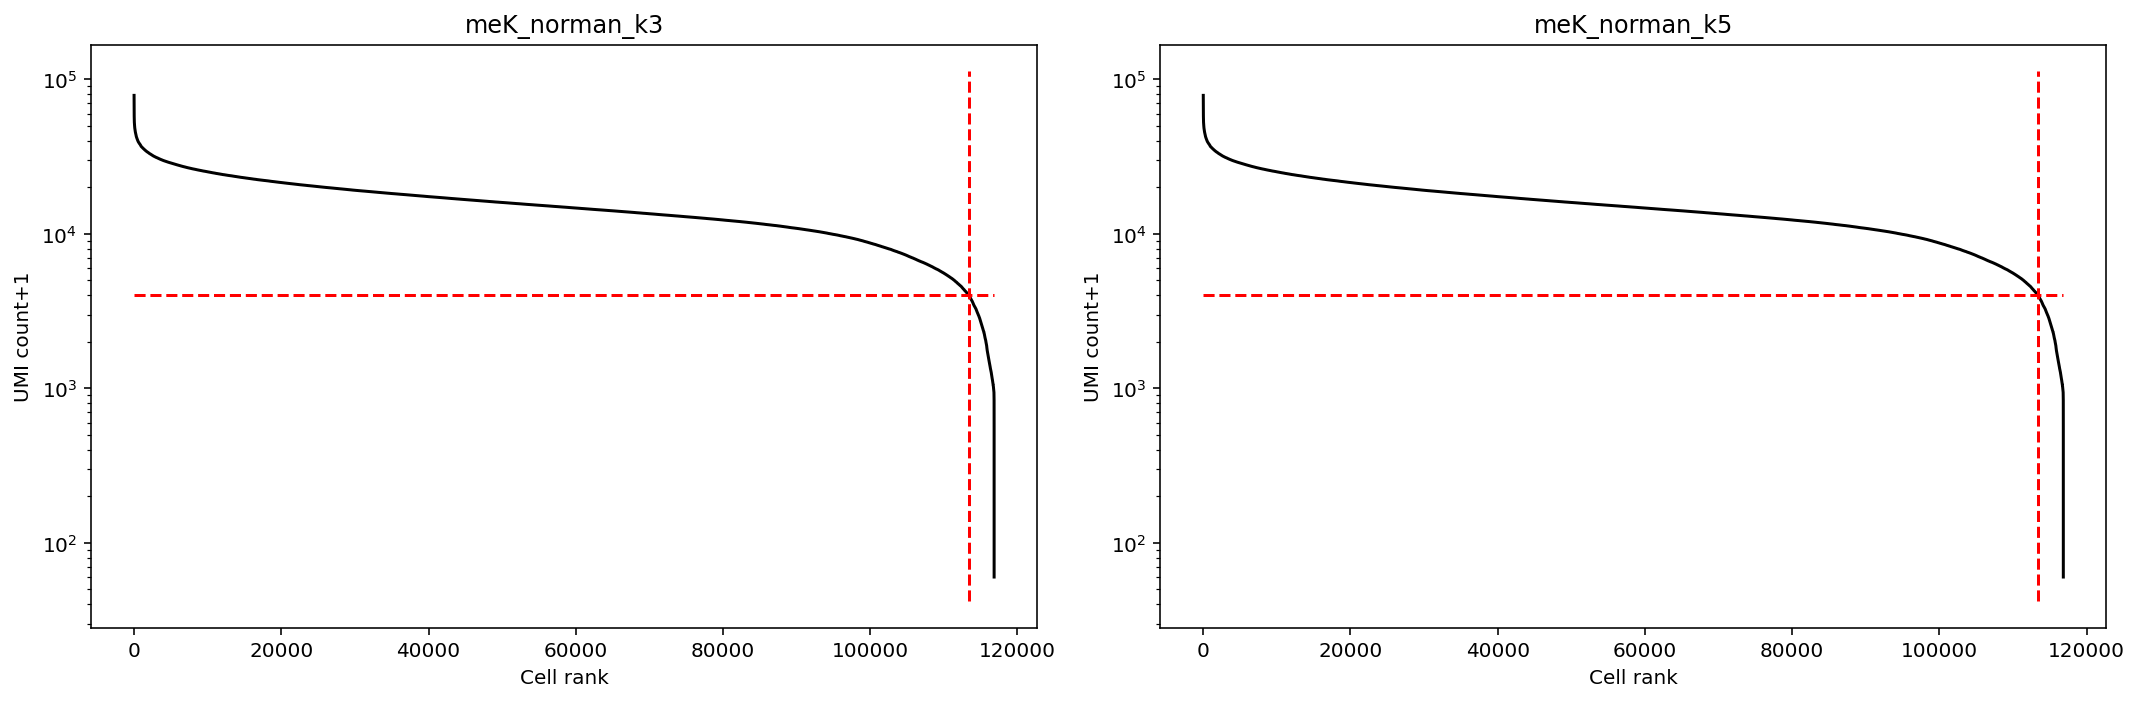

In [1841]:
#Filter for cell barcodes with reasonable UMI threshold, and filter for cells in selected conditions
cf = []
thr_lb = [4e3]*num_ks #4e3,Set UMI count filter for each K run

fig1,ax1 = plt.subplots(1,num_ks,figsize=(15,5))

bcs = bars
n_cells = S.shape[0]


for k in range(num_ks):
    filename = loom_filepaths[k]
    dataset_name = dataset_names[k]


    #Make knee plot with S+U counts
#     monod.preprocess.knee_plot(S.T[final_filt,:]+U.T[final_filt,:],ax1[k],viz=True,thr=thr_lb[k])
#     cf_ = ((S.T[final_filt,:]+U.T[final_filt,:]).sum(0)>thr_lb[k])
    monod.preprocess.knee_plot(S.T+U.T,ax1[k],viz=True,thr=thr_lb[k])
    cf_ = ((S.T+U.T).sum(0)>thr_lb[k])

    #Make filter for low count barcodes
    n_annot_bcs = len(meta['cell_barcode'])
    annot_bcs_in_loom = meta['cell_barcode'].isin(bcs).sum()
    annot_bcs_in_filt_loom = meta['cell_barcode'].isin(bcs[cf_]).sum()
    print(f'Dataset {dataset_name}. \n\t{len(bcs)} barcodes in loom, {cf_.sum()} pass filter. {n_annot_bcs} in annotations; of these, {annot_bcs_in_loom} in loom and {annot_bcs_in_filt_loom} in filtered loom.')

    #Select for barcodes in selected conditions, if applicable
    annot_bcs = meta[(meta['guide_identity'].isin(conds_only))]['cell_barcode'] #filt_ids = with ctrls, conds_only = no ctrl
    cf.append(np.isin(bcs,annot_bcs) & cf_)
    print(f'{len(annot_bcs)} cells in annotations. {np.isin(bcs,annot_bcs).sum()} in loom. {cf[-1].sum()} pass filter.')


    ax1[k].set_title(dataset_name)

!mkdir ./figs
fig_dir = './figs/'
fig_string = fig_dir + 'kneeplots_norman_meK.png'
fig1.tight_layout()
plt.savefig(fig_string,dpi=450)

#110,107 cells

## **Create Output Files and Run meK-Means**

In [1539]:
import logging, sys
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.INFO)
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

In [1540]:
!mkdir ./fits

mkdir: cannot create directory ‘./fits’: File exists


INFO:root:Beginning data preprocessing and filtering.
INFO:root:Directory ./fits/gg_230917_025_meK_norman_1 already exists.
INFO:root:Dataset: meK_norman_k3
INFO:root:1219 cells detected.
INFO:root:36601 features observed, 36169 match genome annotations. 36149 were unique.
INFO:root:1643 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230917_025_meK_norman_1/meK_norman_k3 already exists.
INFO:root:Dataset: meK_norman_k5
INFO:root:1219 cells detected.
INFO:root:36601 features observed, 36169 match genome annotations. 36149 were unique.
INFO:root:1643 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230917_025_meK_norman_1/meK_norman_k5 already exists.
INFO:root:Total of 222 genes selected.
INFO:root:Directory ./fits/gg_230917_025_meK_norman_1/diagnostic_figures already exists.


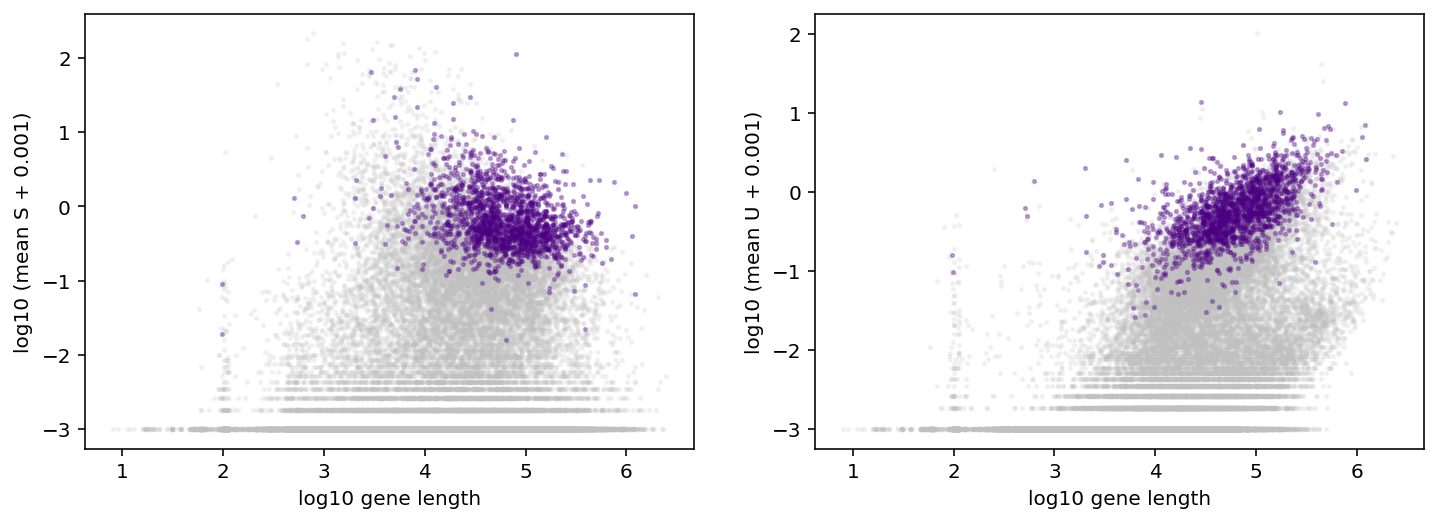

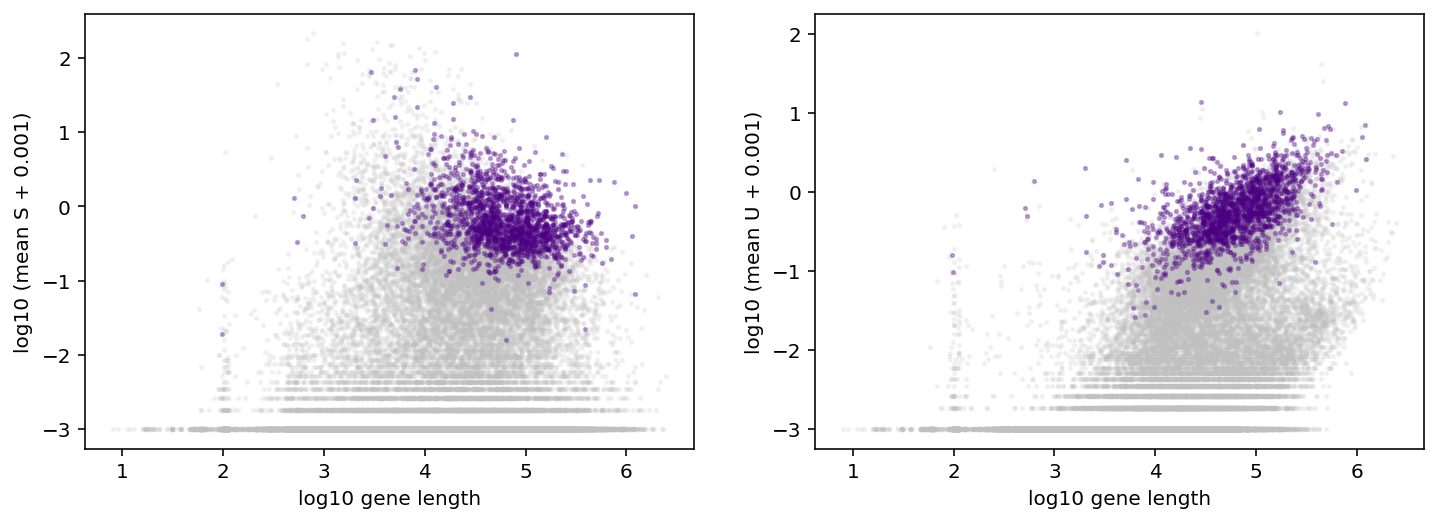

In [1842]:
#Select to run inference on, same genes selected across all runs
dir_string,dataset_strings = monod.preprocess.construct_batch(loom_filepaths, \
                                             transcriptome_filepath, \
                                             dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./fits',meta='meK_norman',batch_id=1,\
                                             datestring='230917', n_genes=len(all_gs_forinf),\
                                             exp_filter_threshold=None,cf=cf,
                                                             genes_to_fit=all_gs_forinf) #genes_to_fit=all_gs_forinf,len(all_gs_forinf)


Save selected genes to genes.csv instead, for meK-Means

In [1843]:
test = pd.read_csv('./fits/gg_230917_025_meK_norman_1/genes.csv',header=None)
test.head()

,0,1,2,3,4,5,6,7,8,9,...,212,213,214,215,216,217,218,219,220,221
0,CLSPN,PUM1,PRDX1,ARID4B,EIF4G3,CD53,POGZ,ASPM,MAPKAPK2,CDC42,...,RBMX,AP1S2,HEPH,IGBP1,MSN,SH3BGRL,ATRX,NBDY,SAT1,SH3KBP1


In [1773]:
# new_pd = pd.DataFrame(columns=range(len(all_gs_forinf)))
# new_pd.loc[0] = all_gs_forinf
# new_pd.to_csv('./fits/gg_230917_025_meK_norman_1/genes.csv',header=None,index=None)
# new_pd.head()

**Run meK-Means**

In [1844]:
#Set bounds from physical parameters search space
phys_lb = [-2.0, -1.8, -1.8 ]
phys_ub = [4.2, 2.5, 2.5]


samp_lb = [-7.157894736842105, -1.525]
samp_ub = [-7.157894736842105, -1.525]

gridsize = [1,1]

In [1845]:
#Set number of epochs
epochs = 10

In [1821]:
# saveCounts

In [1846]:
result_strings = []
for i in range(num_ks):

    #Define model with bursty transcription and Poisson molecule capture/sampling
    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')

    #Set up mminference parameters
    inference_parameters = monod.mminference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,k=ks[i],epochs=epochs,use_lengths = True,
                gradient_params = {'max_iterations':5,'init_pattern':'moments','num_restarts':1})

    #Read in loom file with filtered barcodes
    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[i])

    #Run inference(fit_all_grid_points()) and Save result file strings
    full_result_string = inference_parameters.fit_all_grid_points(30,search_data) 

    result_strings.append(full_result_string)
    
    

INFO:root:Directory ./fits/gg_230917_025_meK_norman_1/meK_norman_k3/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230917_025_meK_norman_1/meK_norman_k3/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: meK_norman_k3
INFO:root:36601 features observed, 36169 match genome annotations. 36149 were unique.
INFO:root:Gene list extracted from ./fits/gg_230917_025_meK_norman_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230917_025_meK_norman_1/meK_norman_k3/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.39s/it]


INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.43s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.10907099 0.43658875 0.45434026]
Q Function:  -584044.1074957213

INFO:root:EM Epoch 2/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.57s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.02517203 0.39390194 0.58092602]
Q Function:  -582896.3678635724

INFO:root:EM Epoch 3/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.42s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.00098042 0.38416586 0.61485372]
Q Function:  -574044.9501832958

INFO:root:EM Epoch 4/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.37s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [8.20344543e-10 2.71558407e-01 7.28441592e-01]
Q Function:  -577567.0312298164

INFO:root:EM Epoch 5/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.76s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [8.20344543e-10 2.11267718e-01 7.88732281e-01]
Q Function:  -574528.6989707903

INFO:root:EM Epoch 6/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.72s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [8.20344543e-10 2.18886742e-01 7.81113257e-01]
Q Function:  -572910.357221667

INFO:root:EM Epoch 7/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.09s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [8.20344543e-10 2.20156000e-01 7.79843999e-01]
Q Function:  -570360.4544056972

INFO:root:EM Epoch 8/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.06s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [8.20344543e-10 2.77339441e-01 7.22660558e-01]
Q Function:  -568024.7496286061

INFO:root:EM Epoch 9/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.71s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [8.20344543e-10 2.73381759e-01 7.26618240e-01]
Q Function:  -569262.6488602222

INFO:root:EM Epoch 10/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.78s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [8.20344543e-10 1.97425232e-01 8.02574767e-01]
Q Function:  -575048.8195343232

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230917_025_meK_norman_1/meK_norman_k3/Bursty_Poisson_1x1/analysis_figures_1 already exists.
INFO:root:Directory ./fits/gg_230917_025_meK_norman_1/meK_norman_k3/Bursty_Poisson_1x1/analysis_figures_2 already exists.
INFO:root:Runtime: 230.1 seconds.
INFO:root:Directory ./fits/gg_230917_025_meK_norman_1/meK_norman_k5/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230917_025_meK_norman_1/meK_norman_k5/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: meK_norman_k5
INFO:root:36601 features observed, 36169 match genome annotations. 36149 were unique.
INFO:root:Gene list extracted from ./fits/gg_230917_025_meK_norman_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230917_025_meK_norman

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.54s/it]


INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.59s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.28891557 0.13349751 0.14947    0.33553425 0.09258266]
Q Function:  -593289.2780577701

INFO:root:EM Epoch 2/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.66s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.32801524 0.00164732 0.00242469 0.59039508 0.07751767]
Q Function:  -592586.1632617854

INFO:root:EM Epoch 3/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.58s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [2.10290313e-01 8.20344541e-10 8.20344541e-10 7.54635305e-01
 3.50743801e-02]
Q Function:  -577088.2543992067

INFO:root:EM Epoch 4/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.23s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.90669934e-01 8.20344541e-10 8.20344541e-10 8.09330063e-01
 8.94486537e-10]
Q Function:  -571450.0173188406

INFO:root:EM Epoch 5/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.10s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.23077113e-01 8.20344541e-10 8.20344541e-10 8.76922884e-01
 8.20344541e-10]
Q Function:  -575360.8965027955

INFO:root:EM Epoch 6/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.76s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [8.27575372e-02 8.20344541e-10 8.20344541e-10 9.17242460e-01
 8.20344541e-10]
Q Function:  -572409.2699023071

INFO:root:EM Epoch 7/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.68s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [7.90272412e-02 8.20344541e-10 8.20344541e-10 9.20972756e-01
 8.20344541e-10]
Q Function:  -571977.3655026422

INFO:root:EM Epoch 8/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.62s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [8.68714073e-02 8.20344541e-10 8.20344541e-10 9.13128590e-01
 8.20344541e-10]
Q Function:  -571651.3678816773

INFO:root:EM Epoch 9/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.84s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [7.57724599e-02 8.20344541e-10 8.20344541e-10 9.24227538e-01
 8.20344541e-10]
Q Function:  -572099.2635032644

INFO:root:EM Epoch 10/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.68s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [7.38164192e-02 8.20344541e-10 8.20344541e-10 9.26183578e-01
 8.20344541e-10]
Q Function:  -572006.998973801

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230917_025_meK_norman_1/meK_norman_k5/Bursty_Poisson_1x1/analysis_figures_0 already exists.
INFO:root:Directory ./fits/gg_230917_025_meK_norman_1/meK_norman_k5/Bursty_Poisson_1x1/analysis_figures_3 already exists.
INFO:root:Runtime: 234.1 seconds.


In [ ]:
#Try including Neg crtl cells + important genes
#CBL/CNN1 vs CTRL or DUSP9/MAPK1 vs CTRL
#Most conds + top ~1k HVGS across all cells
#CBL/CNN1, Another Erythr, CTRL

In [1847]:
#DOes more genes --> more clusters? Try doubling to top 200?

#Read in result files for K=1,5,7 runs
sr = []
for strings in result_strings:
    sr += [[monod.analysis.load_search_results(i) for i in strings]]

sr

INFO:root:Grid scan results loaded from ./fits/gg_230917_025_meK_norman_1/meK_norman_k3/Bursty_Poisson_1x1/grid_scan_results_1.res.
INFO:root:Grid scan results loaded from ./fits/gg_230917_025_meK_norman_1/meK_norman_k3/Bursty_Poisson_1x1/grid_scan_results_2.res.
INFO:root:Grid scan results loaded from ./fits/gg_230917_025_meK_norman_1/meK_norman_k5/Bursty_Poisson_1x1/grid_scan_results_0.res.
INFO:root:Grid scan results loaded from ./fits/gg_230917_025_meK_norman_1/meK_norman_k5/Bursty_Poisson_1x1/grid_scan_results_3.res.


[[<monod.mminference.SearchResults at 0x7f527fc58d90>,

In [1848]:
raws = [d_string+'/raw.sd' for d_string in dataset_strings]
sd = [monod.analysis.load_search_data(w) for w in raws]
sd

INFO:root:Search data loaded from ./fits/gg_230917_025_meK_norman_1/meK_norman_k3/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230917_025_meK_norman_1/meK_norman_k5/raw.sd.


## **Assess Results of meK-Means**

In [1849]:
def vis_metrics(results,title,ks,figsize=(18, 5),s=50,save_file=None):
    '''
    Visualize -Q function and KLD over epochs, and -AIC for final model inference

    results: list of len num_ks, of lists of SearchResults objs per K tested (e.g. [[SearchResults],[SearchResults,SearchResults]] for K=1&2)
    title: title string for leftmost, plot
    ks: list of ks tested (e.g. [1,2])
    figsize: tuple for size of figure
    s: size of dots in scatterplot
    save_file: string, output file to save image

  '''

    num_ks = len(results)
    sets = []
    qs = []
    res = pd.DataFrame()
    aics = pd.DataFrame()
    klds = pd.DataFrame()

    aic = []
    fin_k = []
    kls = []

    epoch = len(results[0][0].all_qs.flatten())
    epos = list(range(1,epoch+1))*num_ks

    for i in range(num_ks):

        qs += list(-1*results[i][0].all_qs.flatten())
        sets += [ks[i]]*epoch
        aic += [results[i][0].aic[0]]
        fin_k += [len(results[i])]


        concat_klds = []
        ks_used = []
        for r in results[i]:
            concat_klds += [r.all_klds[0,:,:]]
            ks_used += [r.assigns]

        concat_klds = np.array(concat_klds)
        concat_klds = concat_klds.reshape((concat_klds.shape[1], concat_klds.shape[2],concat_klds.shape[0]))

        kls += list(np.mean(np.sum(concat_klds[:,:,:],axis=1),axis=1)) #Sum of klds across k clusters


    res['Q'] = qs
    res['KLD'] = kls
    res['epoch'] = epos
    res['setting'] = ['k='+str(j) for j in sets]

    aics['AIC'] = aic
    aics['k'] = [str(j) for j in ks ]
    aics['fin_k'] = fin_k

    #Plot Q function over epochs
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=figsize)

    sns.lineplot(data=res,x='epoch',y='Q',hue='setting',
                    ax=ax[0],palette='Dark2',
                   alpha=0.7,legend=False)
    g1=sns.scatterplot(data=res,x='epoch',y='Q',hue='setting',
                    ax=ax[0],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('-Q')
    ax[0].legend(
          title='Set K')
    ax[0].set_title(title)
    sns.move_legend(g1, "upper left", bbox_to_anchor=(1, 1))


    #Plot klds over epochs
    g2=sns.lineplot(data=res,x='epoch',y='KLD',hue='setting',
                    ax=ax[1],palette='Dark2',
                   alpha=0.7,legend=False)
    sns.scatterplot(data=res,x='epoch',y='KLD',hue='setting',
                    ax=ax[1],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('KLD')
    ax[1].legend(
          title='Set K')
    sns.move_legend(g2, "upper left", bbox_to_anchor=(1, 1))



    #Plot aics
    g3=sns.scatterplot(data=aics,x='fin_k',y='AIC',hue='k', ax=ax[2],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[2].set_xlabel('Final Assigned k')
    ax[2].set_ylabel('-AIC')
    ax[2].legend(
          title='Set K')
    sns.move_legend(g3, "upper left", bbox_to_anchor=(1, 1))


    plt.tight_layout()
    if save_file is None:
        plt.show()
    else:
        plt.savefig(save_file)


In [1850]:
#Plot cluster concordance with true labels and distribution of clusters

def vis_assign(assign,true=None,title='',figsize=(18, 5),save_file=None):
    '''
    Plot distribution of cluster assignments (optional: with previous annotations)

    assign: np.array of cluster assignments (1..k) for each cell
    true: list of user-given cluster assignments (string) for each cell, optional
    title: title string for cluster assignment plot
    figsize: tuple for size of figure
    save_file: string, output file to save image

    '''

    true_copy = list(true)
    assign_copy = list(assign)

    #Plot cluster assignments and distribution of sizes of each cluster
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)

    if true is not None:
        hues = true
    else:
        hues = assign_copy

    g= sns.histplot(x=assign,hue=hues,hue_order=list(np.unique(hues)), kde=False,ax=ax,
                    palette='tab20',multiple="dodge",
                    discrete=True)

    plt.xticks(np.arange(0,np.max(assign)+1))


    ax.set_xlabel('meK-Means Cluster Assignment')
    ax.set_title(title)
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))


    plt.tight_layout()
    if save_file is None:
        plt.show()
    else:
        plt.savefig(save_file)



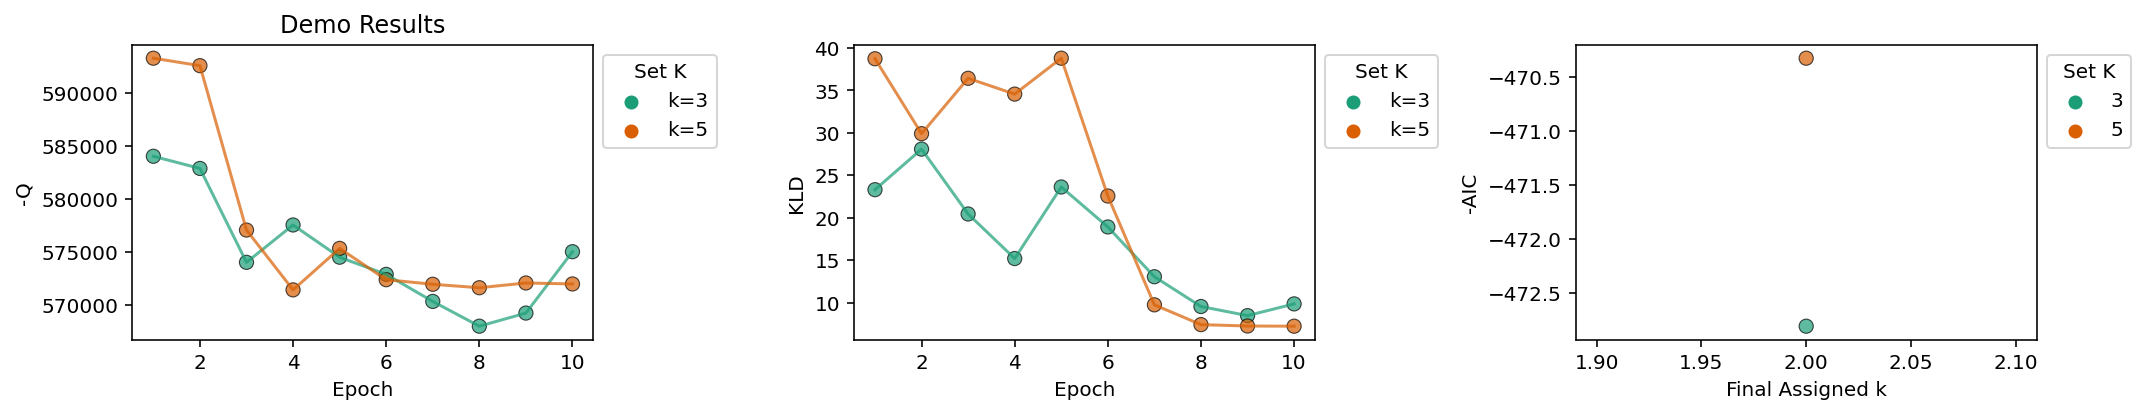

In [1851]:
vis_metrics(sr,'Demo Results',ks,figsize=(15,3))

In [1852]:
#Concatenate cell cluster assignments across all cells and cluster result files
mek_assigns = []
for which_res in range(len(sr)):
    k_res = sr[which_res] #Get all result files for model
    cat_assigns = np.array([None]*int(np.sum(cf[which_res]))) #cat_assigns is empty list of length = no. cell barcodes (after umi filtering)
    for i in range(len(k_res)):
        r = k_res[i]
        cat_assigns[r.filt] = r.assigns #denotes with cluster k cells were assigned to

    mek_assigns += [cat_assigns]

len(mek_assigns)

2

In [1853]:
#Get 'original' cell type assignments for the filtered barcodes/cells, from Yao et al. 2021
all_assigns = [list(meta['guide_identity'][meta['cell_barcode'] == i])[0] for i in bcs[cf[0]]]
print(len(all_assigns))

1219


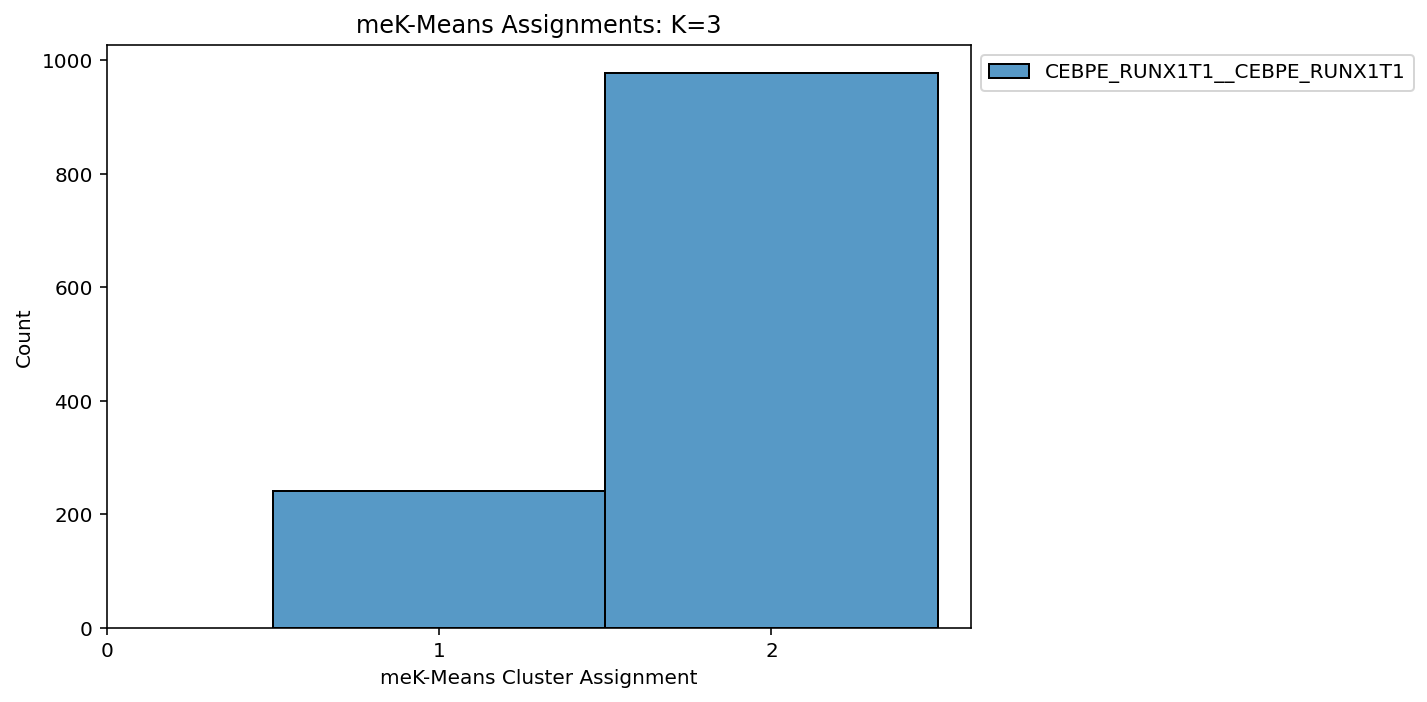

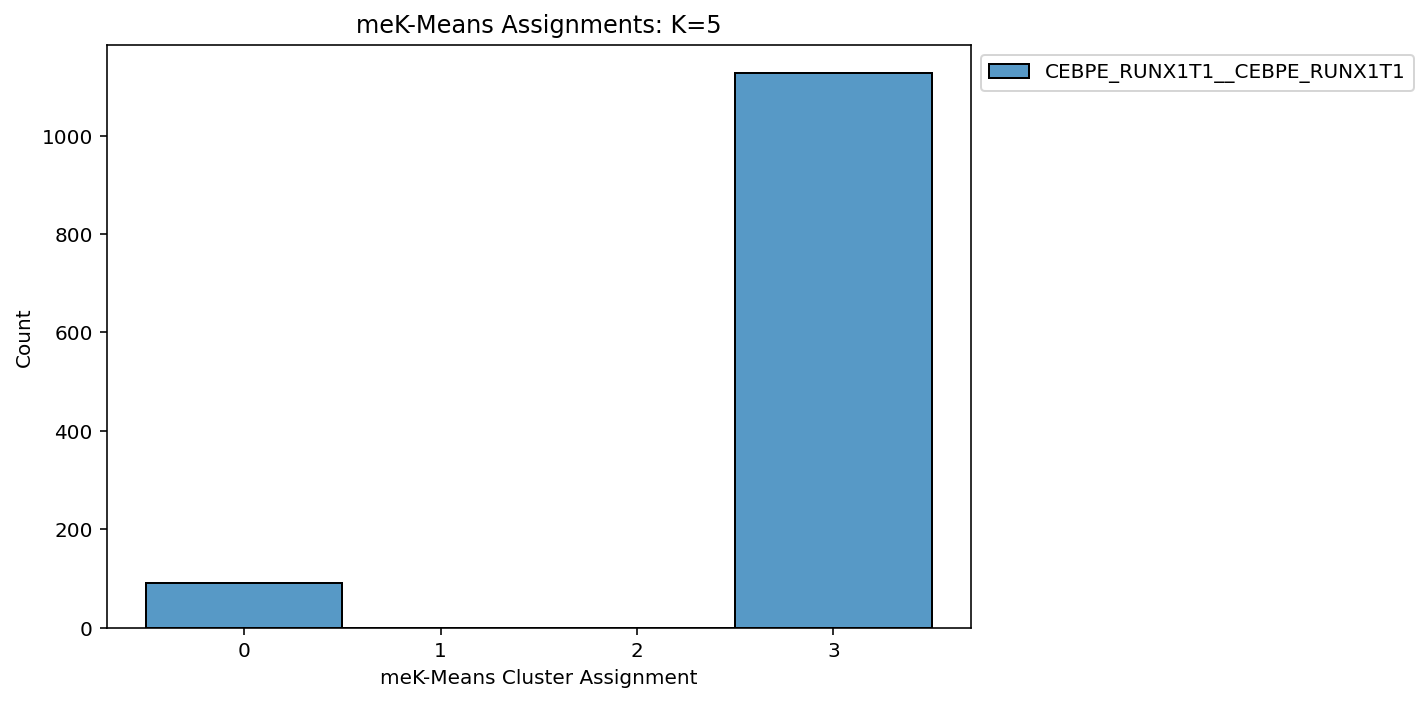

In [1854]:
for i in range(len(mek_assigns)):
    m = mek_assigns[i]
    vis_assign(m,true=all_assigns,title='meK-Means Assignments: K='+str(ks[i]),figsize=(10,5))

In [1855]:
from sklearn.cluster import KMeans

In [1856]:
search_data = monod.extract_data.extract_data(loom_filepaths[0], transcriptome_filepath, dataset_names[0],
                dataset_strings[0], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[0])

INFO:root:Beginning data extraction.
INFO:root:Dataset: meK_norman_k3
INFO:root:36601 features observed, 36169 match genome annotations. 36149 were unique.
INFO:root:Gene list extracted from ./fits/gg_230917_025_meK_norman_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230917_025_meK_norman_1/meK_norman_k3/raw.sd.


In [1857]:
new_S = search_data.layers[0,:,:]
S_t = new_S.T
tots = np.sum(S_t,axis=1)
divids = (1e4/tots)[:,None]
S_t = S_t*divids
S_t = np.log1p(S_t)

kmeans = KMeans(n_clusters=3, random_state=0).fit(S_t)
labs = kmeans.labels_


In [1858]:
new_S = search_data.layers[1,:,:]
S_t = new_S.T
tots = np.sum(S_t,axis=1)
divids = (1e4/tots)[:,None]
S_t = S_t*divids
S_t = np.log1p(S_t)

kmeans = KMeans(n_clusters=3, random_state=0).fit(S_t)
labs2 = kmeans.labels_


<AxesSubplot:ylabel='Count'>

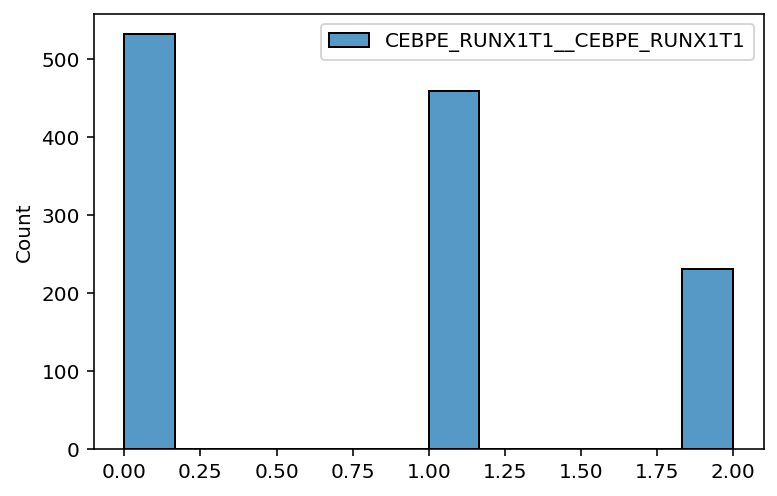

In [1859]:
sns.histplot(x=labs,hue=all_assigns,palette='tab20',multiple='dodge')

<AxesSubplot:ylabel='Count'>

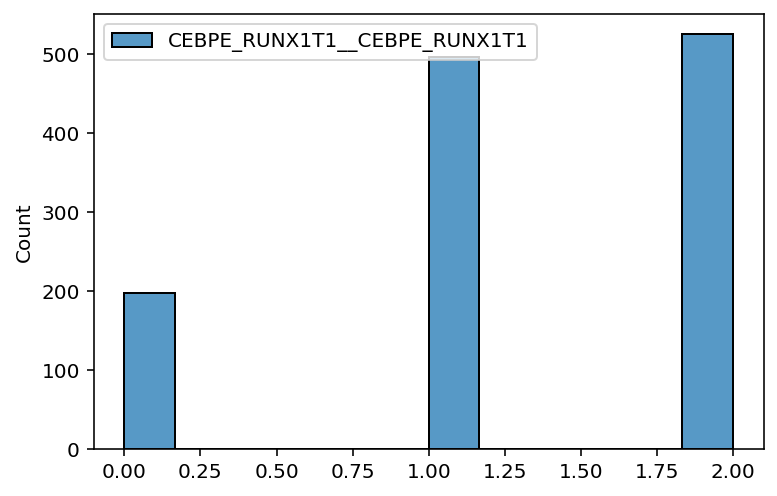

In [1860]:
sns.histplot(x=labs2,hue=all_assigns,palette='tab20',multiple='dodge')


In [1861]:
import igraph as ig
import leidenalg as la
from sklearn.neighbors import kneighbors_graph

A = kneighbors_graph(S_t, 30, mode='connectivity', include_self=True)
sources, targets = A.nonzero()
weights = A[sources, targets]
if isinstance(weights, np.matrix):
    weights = weights.A1
g = ig.Graph(directed=False) #True in scanpy, which is odd
g.add_vertices(A.shape[0])  # this adds adjacency.shape[0] vertices
g.add_edges(list(zip(sources, targets)))

g.es['weight'] = weights

partition_type = la.RBConfigurationVertexPartition


part = la.find_partition(g, partition_type, 
                                weights=np.array(g.es['weight']).astype(np.float64), 
                                n_iterations=-1, resolution_parameter=1.0)


labels = np.array(part.membership)
    

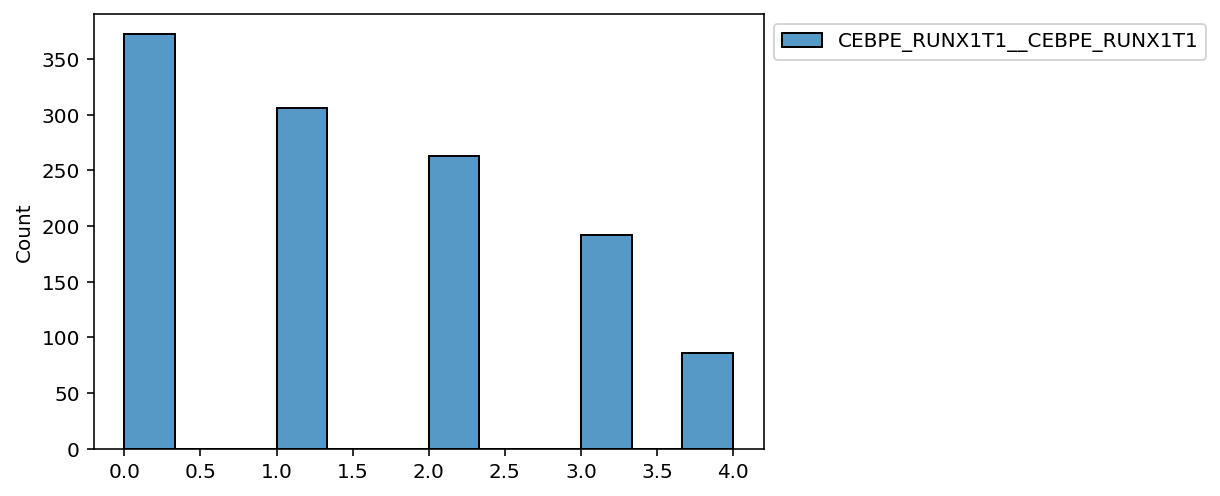

In [1862]:
g=sns.histplot(x=labels,hue=all_assigns,palette='tab20',multiple='dodge')
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))